# Лабораторная работа № 1. Обработка естественного языка.
Вам нужно будет взять [ноутбук](https://drive.google.com/file/d/1euxnmvVeE5byHiTd-axQz4pF9wgEHXmQ/view?usp=sharing) с предсказанием заработной платы, который  Вы разбирали на практике, и улучшить его.

Несколько советов по оформлениею работы:
*   В начале ноутбука добавьте небольшое резюме - что Вами было сделано в ноутбуке: что попробовали, какие результаты получили.
*   Все эксперементы оформите с графиками функции потерь и метриками MAE, MSE. Графики постройте на тренировочных, тестовых и валидационных данных. В конце каждого эксперемента выведите лучшие значения.
*   В конце каждого эксперемента напишите свои выводы. Подкрепите их визуализацией и/или метриками.

**Дедлайн 23 апреля 23:59 МСК**

**РЕЗЮМЕ**

Посмотрела разные варианты нейронных сетей, есть несколько удачных вариантов (2, если говорить точно). Добавление параллельных слоев улучшило ситуацию, но несильно, а вот большое число слоев не дало результата вообще. Единственное, что улучшило изначальную модель - это ранняя остановка.

Изменение пуллинг слоев не дало никаких результатов.

Попробовав различные эмбеддинги могу сказать, что предобученные дали лучший результат, чем замороженные и рандомные, но это улучшение не очень заметно по сравнению со следующими моделями, которые я могу назвать лучшими.

Реккурентные слои вернули мне веру в то, что нейронные сети могут действительно хорошо предсказывать. Но у них есть один большой минус - они работают очень медленно, при желании можно подобрать параллельные слои, которые не уступят им в качестве предсказаний.

На деревья решений было бы интересно посмотреть, если бы код работал быстрее. Надеюсь, что он хотя бы работает.

**ПРЕДОБРАБОТКА ДАННЫХ**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv("./drive/MyDrive/Colab Notebooks/10_classification/Train_rev1.csv", index_col=None)

In [4]:
data.shape

(244768, 12)

In [5]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


Сначала проверим данные на пропуски.


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [7]:
data.nunique()

Id                    244768
Title                 135435
FullDescription       242138
LocationRaw            20986
LocationNormalized      2732
ContractType               2
ContractTime               2
Company                20812
Category                  29
SalaryRaw              97286
SalaryNormalized        8454
SourceName               167
dtype: int64

In [8]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

In [9]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # преобразовали пропущенные данные к строке "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

Теперь преобразуем данные в список токенов

In [10]:
import nltk
data['FullDescription'] = data['FullDescription'].str.lower()
data['Title'] = data['Title'].str.lower()

tokenizer = nltk.tokenize.WordPunctTokenizer()

data['FullDescprition'] = data['FullDescription'].map(lambda x: ' '.join(tokenizer.tokenize(x)))
data['Title'] = data['Title'].map(lambda x: ' '.join(tokenizer.tokenize(x)))

В данных есть слова, которые встречаются всего несколько раз, поэтому посчитаем, сколько раз встречается каждое слово, и выберем только те слова, которые встречались больше 10 раз.

In [11]:
from collections import Counter
token_counts = Counter()

for text in pd.concat([data['Title'], data['FullDescprition']]):
    token_counts.update(text.split()) 

In [12]:
min_count = 10
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

Теперь зададим словарь, где ключом к слову будет сколько раз это слово встретилось.

In [13]:
token_to_id = {t: i for i, t in enumerate(tokens)}

Переведем текст в матрицы.

In [14]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [15]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Преобразуем категориальные данные.

In [16]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

In [17]:
data[categorical_columns].head().to_dict(orient='list')

{'Category': ['Engineering Jobs',
  'Engineering Jobs',
  'Engineering Jobs',
  'Engineering Jobs',
  'Engineering Jobs'],
 'Company': ['Gregory Martin International',
  'Gregory Martin International',
  'Gregory Martin International',
  'Gregory Martin International',
  'Gregory Martin International'],
 'ContractTime': ['permanent',
  'permanent',
  'permanent',
  'permanent',
  'permanent'],
 'ContractType': ['NaN', 'NaN', 'NaN', 'NaN', 'NaN'],
 'LocationNormalized': ['Dorking', 'Glasgow', 'Hampshire', 'Surrey', 'Surrey']}

**1. Развейте СNN архитектуру (2 балла)**

Добавьте в пайплайн

*   Batch Norm (nn.BatchNorm)
*   Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы
*   Больше слоев...
*   Добавьте раннюю остановку

На каких примерах модели ведут себя максимально различно/похоже? Предположите с чем это может быть связано. 

Как модель ведет себя в зависимости от количества обучаемых параметров?


In [18]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [19]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [20]:
import torch
import torch.nn as nn
import torch.functional as F

In [21]:
temp = make_batch(data_train[:3], max_len=10)
temp['Title'].shape, temp['FullDescription'].shape

(torch.Size([3, 7]), torch.Size([3, 10]))

Добавим батчнорм

In [ ]:
class SalaryPredictor_1(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb_t = nn.Embedding(n_tokens, 32)
        self.conv_t = nn.Conv1d(32, 16, 2)
        self.batch_t = nn.BatchNorm1d(16)
        self.pool_t = nn.MaxPool1d(2)

        self.emb_d = nn.Embedding(n_tokens, 32)
        self.conv_d_1 = nn.Conv1d(32, 16, 2)
        self.batch_d = nn.BatchNorm1d(16)
        self.pool_d = nn.MaxPool1d(2)

        self.full_cat = nn.Linear(n_cat_features, hid_size)
     
    def forward(self, batch):
        title = batch['Title']
        title = self.emb_t(title)
        title = title.permute((0, 2, 1))
        title = self.conv_t(title)
        title = self.batch_t(title)
        title = self.pool_t(title).mean(1)

        fulld = batch['FullDescription']
        fulld = self.emb_d(fulld)
        fulld = fulld.permute((0, 2, 1))
        fulld = self.conv_t(fulld)
        fulld = self.batch_d(fulld)
        fulld = self.pool_d(fulld).mean(1)

        cat = self.full_cat(batch['Categorical'])

        concat = torch.cat((title, fulld, cat), dim=1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        return out.squeeze()

In [22]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=torch.device('cpu'), **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

In [23]:
import tqdm

BATCH_SIZE = 16
EPOCHS = 2
DEVICE = torch.device('cpu')

In [24]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    return mse, mae

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


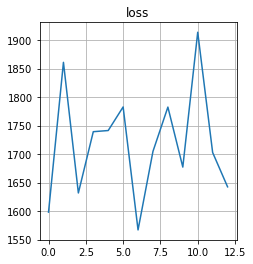

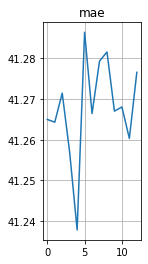

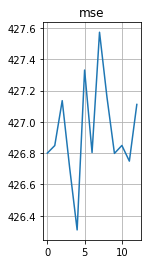

epoch: 1


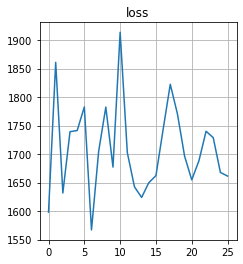

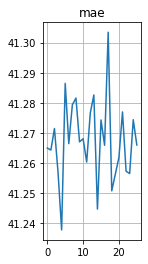

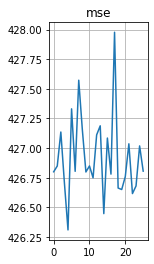

In [ ]:
model_1 = SalaryPredictor_1().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_1.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': [], 'loss': []}

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_1.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_1(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
          m = print_metrics(model_1, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
          metrics['loss'].append(loss)

    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()  
        
    #print_metrics(model_1, data_val)

Добавим параллельные слои

In [ ]:
class SalaryPredictor_2(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb_t = nn.Embedding(n_tokens, 32)
        self.conv_t_1 = nn.Conv1d(32, 16, 2, padding=2)
        self.flat = nn.Flatten()
        self.conv_t_2 = nn.Conv1d(32, 8, 4, padding=3)
        self.conv_t_3 = nn.Conv1d(32, 4, 8, padding=7)
        self.pool_t_1 = nn.MaxPool1d(2)
        self.pool_t_2 = nn.MaxPool1d(4)
        self.pool_t_3 = nn.MaxPool1d(8)

        self.emb_d = nn.Embedding(n_tokens, 32)
        self.conv_d_1 = nn.Conv1d(32, 16, 2, padding=2)
        self.conv_d_2 = nn.Conv1d(32, 8, 4, padding=3)
        self.conv_d_3 = nn.Conv1d(32, 4, 8, padding=7)
        self.pool_d_1 = nn.MaxPool1d(2)
        self.pool_d_2 = nn.MaxPool1d(4)
        self.pool_d_3 = nn.MaxPool1d(8)

        self.full_cat = nn.Linear(n_cat_features, hid_size)
     
    def forward(self, batch):
        title = batch['Title']
        title = self.emb_t(title)
        title = title.permute((0, 2, 1))
        title_1 = self.conv_t_1(title)
        title_2 = self.conv_t_2(title)
        title_3 = self.conv_t_3(title)
        title_1 = self.pool_t_1(title_1).mean(1)
        title_2 = self.pool_t_2(title_2).mean(1)
        title_3 = self.pool_t_3(title_3).mean(1)
        title_1 = self.flat(title_1)
        title_2 = self.flat(title_2)
        title_3 = self.flat(title_3)
        title = torch.cat((title_1, title_2, title_3), dim=1)

        fulld = batch['FullDescription']
        fulld = self.emb_d(fulld)
        fulld = fulld.permute((0, 2, 1))
        fulld_1 = self.conv_d_1(fulld)
        fulld_2 = self.conv_d_2(fulld)
        fulld_3 = self.conv_d_3(fulld)
        fulld_1 = self.pool_d_1(fulld_1).mean(1)
        fulld_2 = self.pool_d_2(fulld_2).mean(1)
        fulld_3 = self.pool_d_3(fulld_3).mean(1)
        fulld_1 = self.flat(fulld_1)
        fulld_2 = self.flat(fulld_2)
        fulld_3 = self.flat(fulld_3)
        fulld = torch.cat((fulld_1, fulld_2, fulld_3), dim=1)

        cat = self.full_cat(batch['Categorical'])

        concat = torch.cat((title, fulld, cat), dim=1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        return out.squeeze()

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


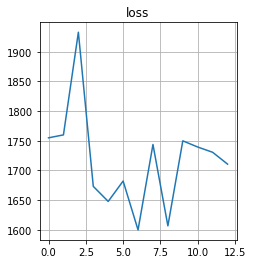

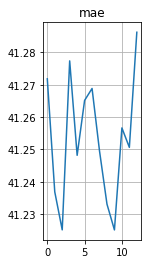

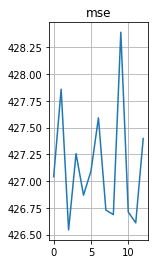

epoch: 1


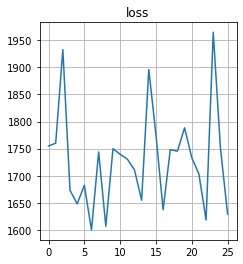

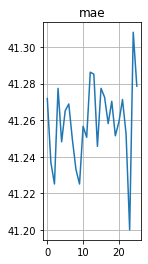

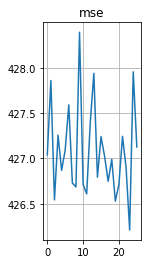

In [ ]:
model_2 = SalaryPredictor_2().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_2.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': [], 'loss': []}

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_2.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_2(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
          m = print_metrics(model_2, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
          metrics['loss'].append(loss)

    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()  

Попробуем добавить больше слоев

In [ ]:
class SalaryPredictor_3(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb_t = nn.Embedding(n_tokens, 32)
        self.batch_t = nn.BatchNorm1d(32)
        self.conv_t_1 = nn.Conv1d(32, 32, 2)
        self.relu_t = nn.ReLU()
        self.flat = nn.Flatten()
        self.conv_t_2 = nn.Conv1d(32, 16, 2)
        self.conv_t_3 = nn.Conv1d(16, 16, 1)
        self.pool_t_1 = nn.MaxPool1d(2)
        self.pool_t_2 = nn.MaxPool1d(2)
        self.pool_t_3 = nn.MaxPool1d(1)
        #self.fc_t = nn.Linear(256, 22)

        self.emb_d = nn.Embedding(n_tokens, 32)
        self.batch_d = nn.BatchNorm1d(32)
        self.conv_d_1 = nn.Conv1d(32, 32, 2)
        self.relu_d = nn.ReLU()
        self.conv_d_2 = nn.Conv1d(32, 16, 2)
        self.conv_d_3 = nn.Conv1d(16, 16, 1)
        self.pool_d_1 = nn.MaxPool1d(2)
        self.pool_d_2 = nn.MaxPool1d(2)
        self.pool_d_3 = nn.MaxPool1d(1)
        #self.fc_d = nn.Linear(256, 22)

        self.full_cat = nn.Linear(n_cat_features, hid_size)
     
    def forward(self, batch):
        title = batch['Title']
        title = self.emb_t(title)
        title = title.permute((0, 2, 1))
        title = self.batch_t(title)
        title = self.conv_t_1(title)
        title = self.relu_t(title)
        title = self.conv_t_2(title)
        title = self.relu_t(title)
        title = self.pool_t_2(title)
        title = self.relu_t(title)
        title = self.conv_t_3(title)
        title = self.relu_t(title)
        title = self.pool_t_3(title)
        title = self.flat(title)
        #title = self.fc_t(title)

        fulld = batch['FullDescription']
        fulld = self.emb_d(fulld)
        fulld = fulld.permute((0, 2, 1))
        fulld = self.batch_d(fulld)
        fulld = self.conv_d_1(fulld)
        fulld = self.relu_d(fulld)
        fulld = self.conv_d_2(fulld)
        fulld = self.relu_d(fulld)
        fulld = self.pool_d_2(fulld)
        fulld = self.relu_d(fulld)
        fulld = self.conv_d_3(fulld)
        fulld = self.relu_d(fulld)
        fulld = self.pool_d_3(fulld)
        fulld = self.flat(fulld)
        #fulld = self.fc_d(fulld)

        cat = self.full_cat(batch['Categorical'])

        concat = torch.cat((title, fulld, cat), dim=1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        return out.squeeze()

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


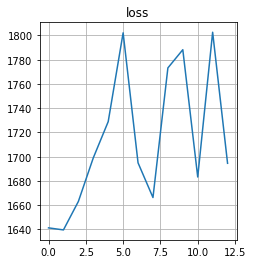

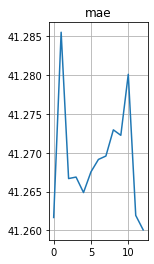

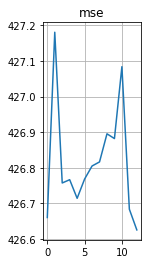

epoch: 1


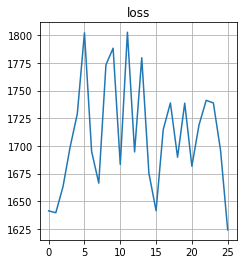

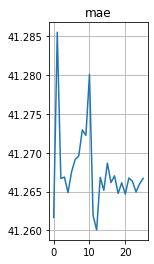

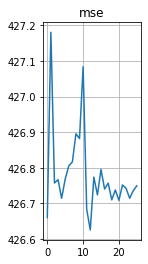

In [ ]:
model_3 = SalaryPredictor_3().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_3.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': [], 'loss': []}

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_3.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_3(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
          m = print_metrics(model_3, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
          metrics['loss'].append(loss)

    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()  

Теперь добавим к лучшей модели (3я модель) раннюю остановку

In [31]:
class EarlyStopping:
  def __init__(self, patience, eps):
    self.patience = patience
    self.eps = eps
    self.prev_loss = 10000
    self.stagnant_epochs_number = 0
    self.delta = 0

  def toStop(self, loss):
    if self.prev_loss == 10000:
      self.delta = loss
    else:
      self.delta = self.prev_loss - loss

    if self.delta < self.eps:
      self.stagnant_epochs_number += 1
      return self.stagnant_epochs_number >= self.patience

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


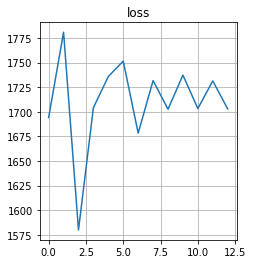

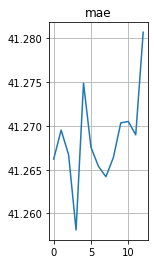

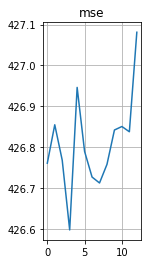

epoch: 1


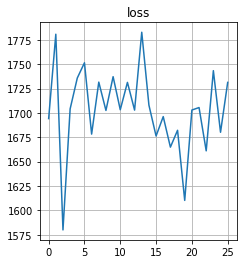

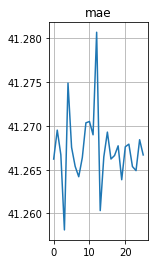

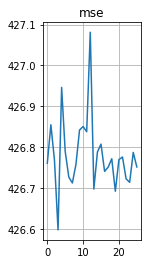

In [ ]:
model_3 = SalaryPredictor_3().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_3.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': [], 'loss': []}
stopping = EarlyStopping(EPOCHS, 50)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_3.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_3(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])

        if stopping.toStop(loss):
          break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
          m = print_metrics(model_3, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
          metrics['loss'].append(loss)

    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()  

**ВЫВОД**

Увеличение числа слоев, как и добавление параллельных слоев, не сильно улучшили ошибку, она оставалась в тех же пределах, а вот ранняя остановка добавила постоянности в изменение ошибки. При этом по времени, как и ожидалось, модели с большим числом слоев проигрывает. Возможно этот результат связан с тем, что я попробовала только на двух эпохах, либо же нужно было попробовать несколько параллельных моделей с большим числом слоев, но это заняло бы много времени, тогда как ранняя остановка дала неплохие результаты.

**2. Pooling слои стандартные (1 балла)**

*   Опишите своими словами как работает Pooling слой.
*   Взять максимум по временной компоненте (незавимисо для каждой фичи)
*   Взять среднее по временной компоненте (исключая PAD символы)

Применять можно к любой архитектуре (CNN/RNN)

1. Pooling слой нужен для того, чтобы уменьшить размер тензора. Для этого тензор  делим на одинаковые блоки, в каждом таком блоке вычисляем выбранную функцию (до этого в нейронках из первого задания мы брали максимум) и создаем новый тензор из значений, полученных для каждого блока. 

2. Максимум по временной компоненте брали в первом задании, поэтому сразу возьмем среднее.

3. Среднее по временной компоненте:

In [ ]:
class SalaryPredictor_5(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb_t = nn.Embedding(n_tokens, 32)
        self.conv_t = nn.Conv1d(32, 16, 2)
        self.pool_t = nn.AvgPool1d(2, count_include_pad=False)

        self.emb_d = nn.Embedding(n_tokens, 32)
        self.conv_d = nn.Conv1d(32, 16, 2)
        self.pool_d = nn.AvgPool1d(2, count_include_pad=False)

        self.full_cat = nn.Linear(n_cat_features, hid_size)
     
    def forward(self, batch):
        title = batch['Title']
        title = self.emb_t(title)
        title = title.permute((0, 2, 1))
        title = self.conv_t(title)
        title = self.pool_t(title).mean(1)

        fulld = batch['FullDescription']
        fulld = self.emb_d(fulld)
        fulld = fulld.permute((0, 2, 1))
        fulld = self.conv_d(fulld)
        fulld = self.pool_d(fulld).mean(1)

        cat = self.full_cat(batch['Categorical'])

        concat = torch.cat((title, fulld, cat), dim=1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        return out.squeeze()

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


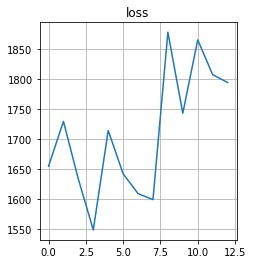

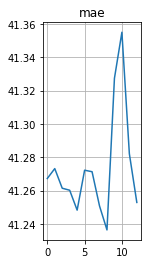

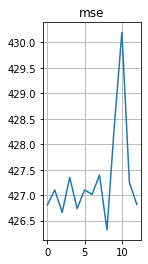

epoch: 1


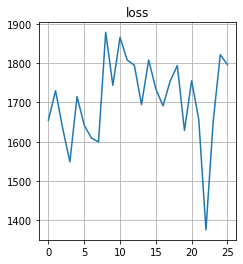

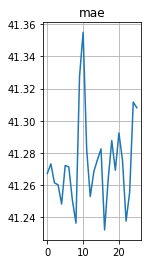

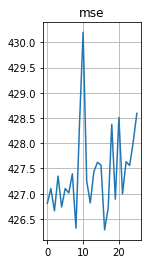

In [ ]:
model_5 = SalaryPredictor_5().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_5.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': [], 'loss': []}

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_5.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_5(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
          m = print_metrics(model_5, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
          metrics['loss'].append(loss)

    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()  

**ВЫВОД**

Можем увидеть, что результат вышел чуть лучше, чем с MaxPooling. Но при этом обогнать раннюю остановку все равно не удалось.

**3. Используйте предобученные эмбеддинги (2 балла)**

*   Загрузите предобученные эмбеддинги с помощью gensim.downloader.load
*   Используйте метод [from_pretrained](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) слоя torch.nn.Embedding для инициализации эмбеддингов с помощью предобученных весов. Можете попбровать несколько типов предобученных эмбеддингов.
*   Проведите эксперементы с обучаемыми/замороженными весами эмбеддингов.
Используйте одни и те же эмбеддинги для Title и FullDescription.

Сравните результаты:
1.   Эмбеддингов, инициализируемых случайно из $$\mathcal{N}(0,1)$$ (по умолчанию у слоя torch.nn.Embedding)
2.   Предобученных эмбеддингов с замороженными весами
3.   Предобученных эмбеддингов с обучаемыми весами

Что изменяется в поведении модели? Какой эксперимент дал лучший результат?

1. Эти эмбеддинги были реализованы в первом задании.

2. Попробуем с замороженными весами

In [ ]:
from gensim.downloader import load as gs_load

In [ ]:
class SalaryPredictor_6(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        model = gs_load("glove-twitter-25")
        weights = torch.FloatTensor(model.vectors)
        embedding = nn.Embedding.from_pretrained(weights)
        self.emb_t = embedding
        self.conv_t = nn.Conv1d(25, 5, 2)
        self.pool_t = nn.MaxPool1d(2)

        self.emb_d = embedding
        self.conv_d = nn.Conv1d(25, 16, 2)
        self.pool_d = nn.MaxPool1d(2)

        self.full_cat = nn.Linear(n_cat_features, hid_size)


    def forward(self, batch):
        title = batch['Title']
        title = self.emb_t(title)
        title = title.permute((0, 2, 1))
        title = self.conv_t(title)
        title = self.pool_t(title).mean(1)

        fulld = batch['FullDescription']
        fulld = self.emb_d(fulld)
        fulld = fulld.permute((0, 2, 1))
        fulld = self.conv_d(fulld)
        fulld = self.pool_d(fulld).mean(1)

        cat = batch['Categorical']
        cat = (self.full_cat(cat))
        
        concat = torch.cat((title, fulld, cat), dim = 1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        
        return out.squeeze()

[==================================================] 100.0% 104.8/104.8MB downloaded
epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


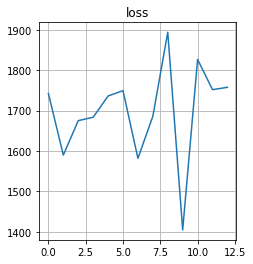

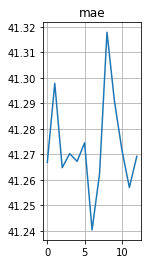

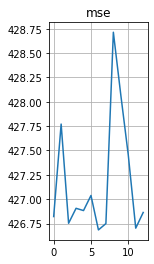

epoch: 1


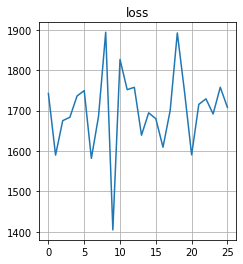

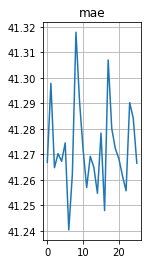

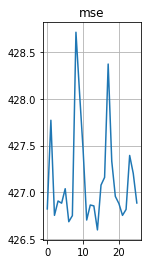

In [ ]:
model_6 = SalaryPredictor_6().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_6.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': [], 'loss': []}

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_6.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_6(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
          m = print_metrics(model_6, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
          metrics['loss'].append(loss)

    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()  

3. Посмотрим на предобученные веса

In [ ]:
class SalaryPredictor_7(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        model = gs_load("glove-twitter-25")
        weights = torch.FloatTensor(model.vectors)
        embedding = nn.Embedding.from_pretrained(weights, freeze=False)
        self.emb_t = embedding
        self.conv_t = nn.Conv1d(25, 5, 2)
        self.pool_t = nn.MaxPool1d(2)

        self.emb_d = embedding
        self.conv_d = nn.Conv1d(25, 16, 2)
        self.pool_d = nn.MaxPool1d(2)

        self.full_cat = nn.Linear(n_cat_features, hid_size)


    def forward(self, batch):
        title = batch['Title']
        title = self.emb_t(title)
        title = title.permute((0, 2, 1))
        title = self.conv_t(title)
        title = self.pool_t(title).mean(1)

        fulld = batch['FullDescription']
        fulld = self.emb_d(fulld)
        fulld = fulld.permute((0, 2, 1))
        fulld = self.conv_d(fulld)
        fulld = self.pool_d(fulld).mean(1)

        cat = batch['Categorical']
        cat = (self.full_cat(cat))
        
        concat = torch.cat((title, fulld, cat), dim = 1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        return out.squeeze()

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


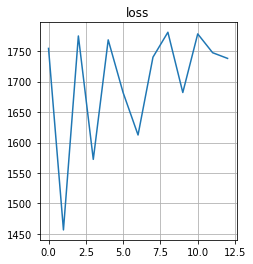

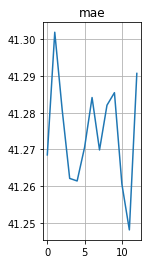

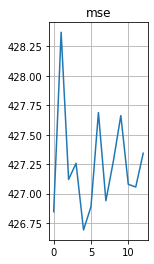

epoch: 1


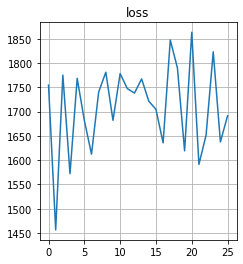

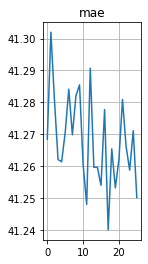

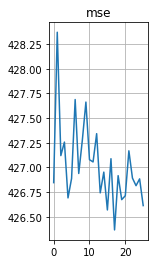

In [ ]:
model_7 = SalaryPredictor_7().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_7.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': [], 'loss': []}

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_7.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_7(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
          m = print_metrics(model_7, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
          metrics['loss'].append(loss)

    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()  

**ВЫВОД**

Обе модели показывают не очень стабильный рост точности, но у модели с преобученными весами ошибка ниже, чем у модели с замороженными. При этом у нее не так сильно изменяется loss, как у модели с замороженными. У модели с предобученными весами, что ошибка постепенно стабилизируется, тогда как у модели с замороженными loss "скачет". Это можно объяснить тем, что у модели с предобученными весами веса меняется в сторону улучшения в процессе обучения модели.

**4. Замените сверточные слои на рекуррентные (3 балла)**

* Замените сверточне слоим рекуррентными LSTM/GRU.
* Проведите эксперимент с однонаправленной и двунаправленной рекуррентной нейросетью
* Попробуйте найти удачный микс рекуррентных и сверточных слоев. Попробуйте разные миксы для Title и FullDescription

Реккурентная для FullDescription:

In [25]:
class SalaryPredictor_8(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), num_of_h_layers = 2, hid_size=8):
        super().__init__()
        self.flat = nn.Flatten()
        self.emb_t = nn.Embedding(n_tokens, 32)
        
        self.batch_t = nn.BatchNorm1d(32)
        self.conv_t = nn.Conv1d(32, 16, 2, padding=2)
        self.relu_t = nn.ReLU()
        self.pool_t = nn.MaxPool1d(2)

        self.emb_d = nn.Embedding(n_tokens, 32)
        self.batch_d = nn.BatchNorm1d(32)

        self.num_hidd_l = num_of_h_layers
        self.hid_size = hid_size
        self.rnn = nn.GRU(32, hid_size, num_of_h_layers, batch_first=True)
        self.fc = nn.Linear(hid_size, 1)
        

        self.full_cat = nn.Linear(n_cat_features, hid_size)

        self.soft = nn.Softmax(dim=1)


    def forward(self, batch):
        title = batch['Title']
        title = self.emb_t(title)
        title = title.permute((0, 2, 1))
        title = self.conv_t(title)
        title = self.relu_t(title)
        title = self.pool_t(title).mean(1)
        title = self.flat(title)

        
        fulld = batch['FullDescription']
        fulld = self.emb_d(fulld)
        #description = description.permute((0, 2, 1))
        

        h0 = torch.zeros(self.num_hidd_l, fulld.size(0), self.hid_size)
        fulld, _ = self.rnn(fulld, h0)
        fulld = fulld[:, -1, :]
        fulld = self.fc(fulld)

        cat = batch['Categorical']
        cat = (self.full_cat(cat))
        
        concat = torch.cat((title, fulld, cat), dim = 1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        out = self.soft(out)
        
        return out.squeeze()

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


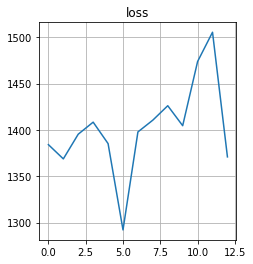

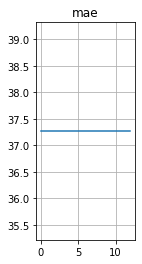

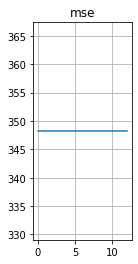

epoch: 1


In [ ]:
model_8 = SalaryPredictor_8().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_8.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': [], 'loss': []}

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_8.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_8(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
          m = print_metrics(model_8, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
          metrics['loss'].append(loss)

    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()  

Вторую эпоху не стала ждать, так как первая выполнялась 1,5 часа. График второй эпохи я видела, результат схож со второй эпохой для Title.

Реккурентная для Title:

In [ ]:
class SalaryPredictor_9(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), num_of_h_layers = 2, hid_size=8):
        super().__init__()
        self.flat = nn.Flatten()
        self.emb_t = nn.Embedding(n_tokens, 32)   
        self.batch_t = nn.BatchNorm1d(32)

        self.emb_d = nn.Embedding(n_tokens, 32)
        self.batch_d = nn.BatchNorm1d(32)
        self.conv_d = nn.Conv1d(32, 16, 2, padding=2)
        self.relu_d = nn.ReLU()
        self.pool_d = nn.MaxPool1d(2)

        self.num_hidd_l = num_of_h_layers
        self.hid_size = hid_size
        self.rnn = nn.GRU(32, hid_size, num_of_h_layers, batch_first=True)
        self.fc = nn.Linear(hid_size, 1)
        
        self.full_cat = nn.Linear(n_cat_features, hid_size)

        self.soft = nn.Softmax(dim=1)

    def forward(self, batch):
        title = batch['Title']
        title = self.emb_t(title)
        
        fulld = batch['FullDescription']
        fulld = self.emb_d(fulld)
        fulld = fulld.permute((0, 2, 1))
        fulld = self.conv_d(fulld)
        fulld = self.relu_d(fulld)
        fulld = self.pool_d(fulld).mean(1)
        fulld = self.flat(fulld)
        

        h0 = torch.zeros(self.num_hidd_l, title.size(0), self.hid_size)
        title, _ = self.rnn(title, h0)
        title = title[:, -1, :]
        title = self.fc(title)

        cat = batch['Categorical']
        cat = (self.full_cat(cat))
        
        concat = torch.cat((title, fulld, cat), dim = 1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        out = self.soft(out)
        
        return out.squeeze()


epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


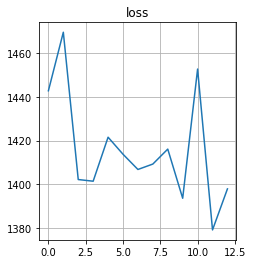

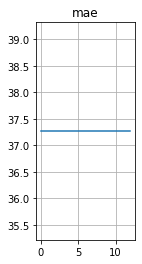

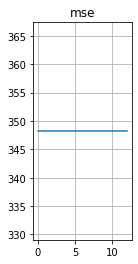

epoch: 1


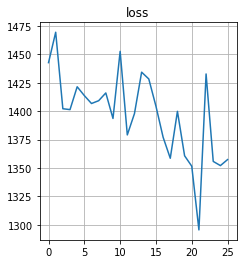

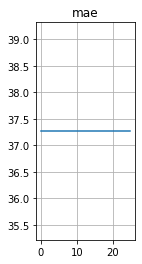

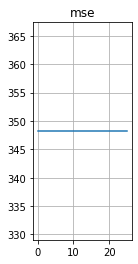

In [ ]:
model_9 = SalaryPredictor_9().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_9.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': [], 'loss': []}

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_9.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_9(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
          m = print_metrics(model_9, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
          metrics['loss'].append(loss)

    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()  

Двунаправленность:

In [ ]:
class SalaryPredictor_9_2(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), num_of_h_layers = 2, hid_size=8):
        super().__init__()
        self.flat = nn.Flatten()
        self.emb_t = nn.Embedding(n_tokens, 32)   
        self.batch_t = nn.BatchNorm1d(32)

        self.emb_d = nn.Embedding(n_tokens, 32)
        self.batch_d = nn.BatchNorm1d(32)
        self.conv_d = nn.Conv1d(32, 16, 2, padding=2)
        self.relu_d = nn.ReLU()
        self.pool_d = nn.MaxPool1d(2)

        self.num_hidd_l = num_of_h_layers
        self.hid_size = hid_size
        self.rnn = nn.GRU(32 , hid_size, num_of_h_layers, batch_first = True, bidirectional=True)
        self.fc = nn.Linear(16, 16)
        
        self.full_cat = nn.Linear(n_cat_features, hid_size)

        self.soft = nn.Softmax(dim=1)

    def forward(self, batch):
        title = batch['Title']
        title = self.emb_t(title)
        
        fulld = batch['FullDescription']
        fulld = self.emb_d(fulld)
        fulld = fulld.permute((0, 2, 1))
        fulld = self.conv_d(fulld)
        fulld = self.relu_d(fulld)
        fulld = self.pool_d(fulld).mean(1)
        fulld = self.flat(fulld)
        

        h0 = torch.zeros(self.num_hidd_l+2, title.size(0), self.hid_size)
        title, _ = self.rnn(title, h0)
        title = title[:, -1, :]
        title = self.fc(title)

        categorical = batch['Categorical']
        categorical = (self.full_cat(categorical))
        
        concat = torch.cat((title, fulld, categorical), dim = 1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        out = self.soft(out)
        
        return out.squeeze()

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


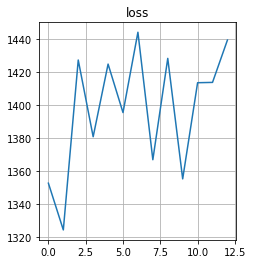

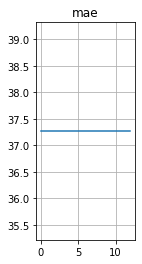

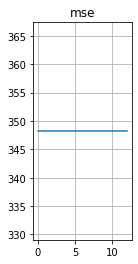

epoch: 1


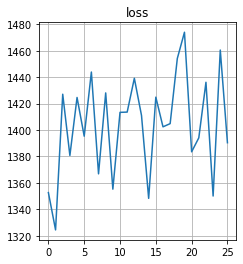

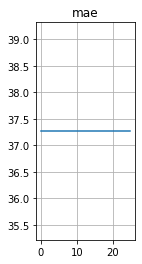

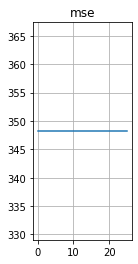

In [ ]:
model_9_2 = SalaryPredictor_9_2().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_9_2.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': [], 'loss': []}

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_9_2.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_9_2(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
          m = print_metrics(model_9_2, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
          metrics['loss'].append(loss)

    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()  

**ВЫВОД**

Из графиков видно, что реккурентные модели дали лучший результат. Причем если у каждой модели loss меняется по-своему, то вот MAE и MSE дают стабильно одно и то же значение у каждой функции. Это связано с тем, что CNN применимо для компьютерного зрения, а RNN больше подходит для обработки естественного языка + может использовать уже сгенерированный вывод для дальнейшего использования. Мне кажется, что модели с реккурентным слоем по каждому признаки дали лучший результат, чем модель с двунаправленностью, так как она ведет себя слишком хаотично по сравнению с первыми двумя. Также у первых двух можно увидеть постепенное снижение loss, а вот про последнюю этого уже нельзя сказать.

**5. Вытащите признаки из нейронной сети и используйте их в ансамбле деревьев решений. (2 балла)**

* Вытащите признаки с предпоследнего слоя обученной нейросети и передайте их в ансамбль деревьев решений.
* Сравните результаты работы лучшей нейросети и ансамбля деревьев решений, построенном на признаках из этой нейросети. Сможет ли замена последнего слоя на ансамбль деревьев решений улучшить результат?

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
clf_param = model_8.layer[0].weight

In [ ]:
(trainData, testData, trainLabel, testLabel) = train_test_split(data.drop(columns='Log1pSalary'), data['Log1pSalary'], test_size=0.2)

In [ ]:
clf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=42, class_weight=clf_param)
clf.fit(trainData, trainLabel)

In [ ]:
preds = clf.predict(testData)
mae_rf = metrics.mean_absolute_error(testLabel, preds)
mse_rf = metrics.mean_squared_error(testLabel, preds)

**6. Pooling слои продвинутые* (3 балла)**

Реализуйте и примените
Softmax-pooling:$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

Attentive pooling$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, где $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$и $NN_{attn}$ полносвязный слой.